In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Template 02
- multi-class - Fashion MNIST dataset (all 60000 images)

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [4]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import tensorflow as tf

# from utils.helper import fn_plot_confusion_matrix

In [5]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [6]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 30 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [9]:
train_df = pd.read_csv('ionosphere.data', header = 0)
test_df = pd.read_csv('fashion-mnist_test.csv', header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [11]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [13]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [16]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

## Whats in the data?

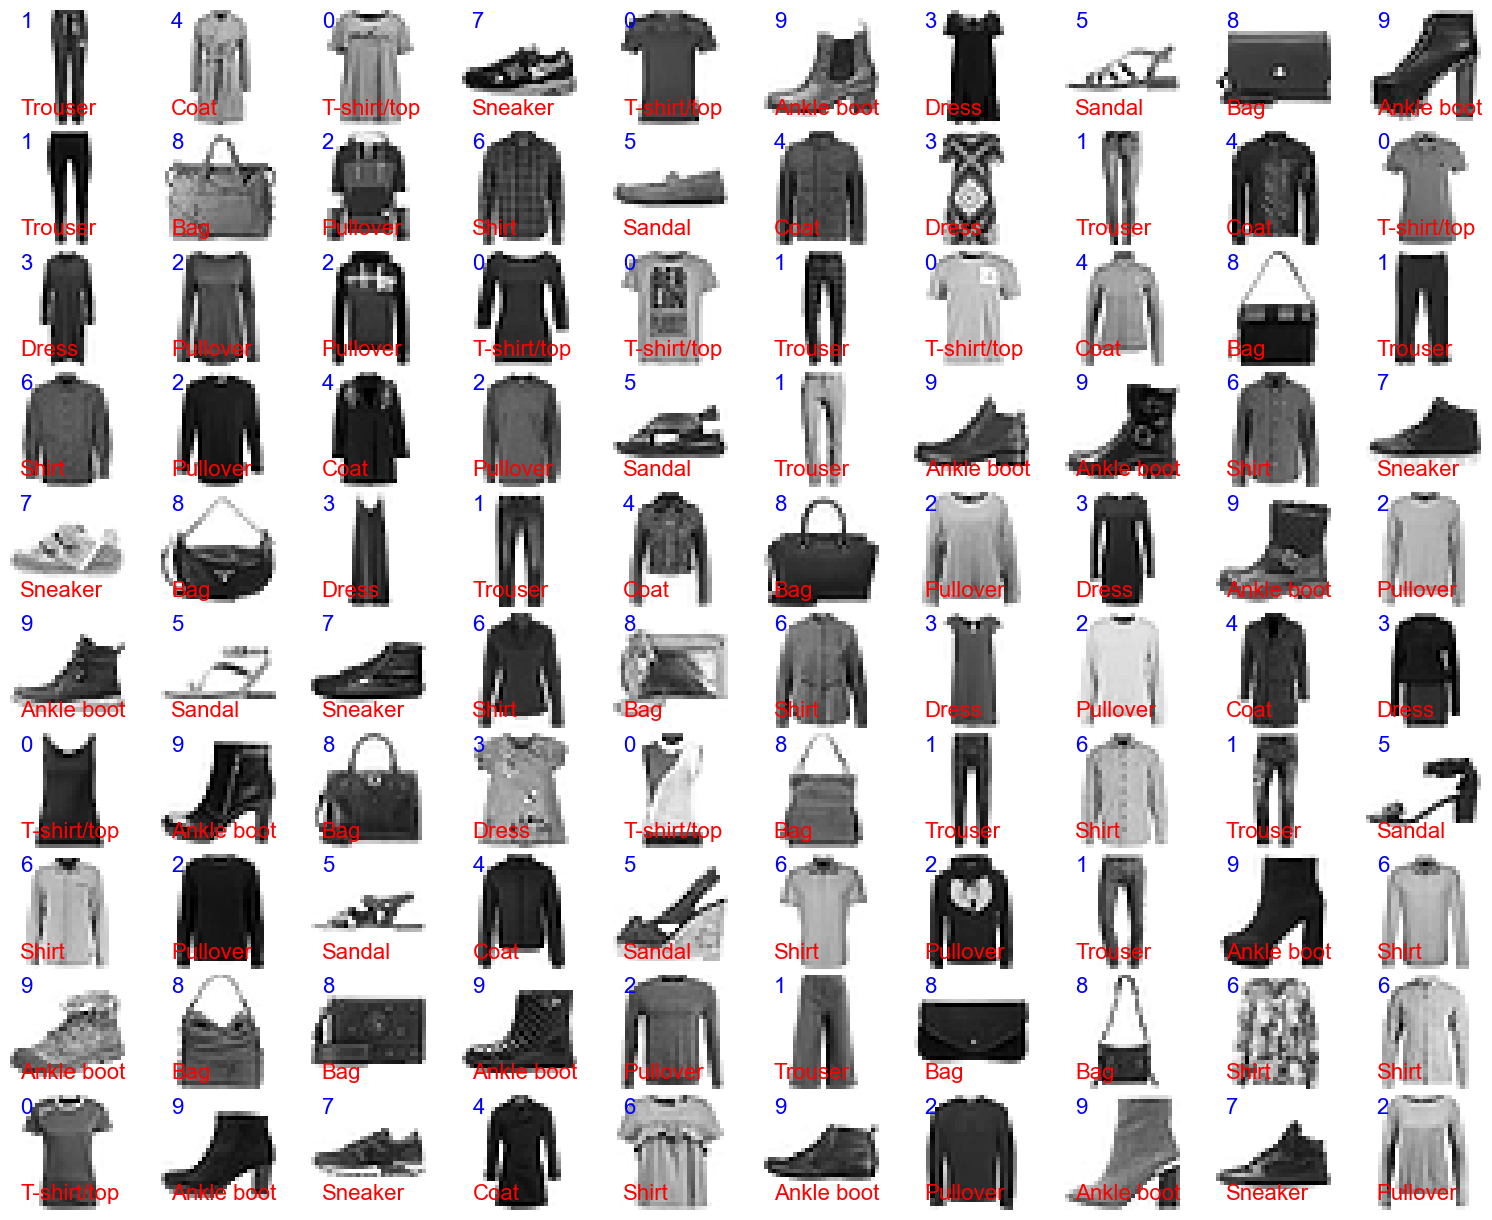

In [18]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)   # add number (class) of the image
    
    ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)   # add name of the image
    
plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [21]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [22]:
X_train = X_train / 255.0

X_test = X_test / 255.0

In [23]:
X_train.shape

(60000, 784)

In [24]:
X_test.shape

(10000, 784)

In [25]:
model = tf.keras.Sequential([
    tf.keras.Input(shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(196, activation= 'relu'),
    tf.keras.layers.Dense(49, activation= 'relu'),

    tf.keras.layers.Dense(10)

])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 196)                 │         153,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 49)                  │           9,653 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7836 - loss: 0.6182 - val_accuracy: 0.8592 - val_loss: 0.3887
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8638 - loss: 0.3747 - val_accuracy: 0.8643 - val_loss: 0.3772
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8777 - loss: 0.3310 - val_accuracy: 0.8790 - val_loss: 0.3279
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8840 - loss: 0.3135 - val_accuracy: 0.8790 - val_loss: 0.3277
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8912 - loss: 0.2967 - val_accuracy: 0.8842 - val_loss: 0.3235
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8953 - loss: 0.2776 - val_accuracy: 0.8840 - val_loss: 0.3110
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8999 - loss: 0.2660 - val_accuracy: 0.8806 - val_loss: 0.3236
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9032 - loss: 0.2512 - 

In [27]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.826117,0.490489,0.8592,0.388680
1,0.865167,0.371430,0.8643,0.377159
2,0.878000,0.332956,0.8790,0.327854
3,0.884633,0.313666,0.8790,0.327699
4,0.892300,0.292684,0.8842,0.323458


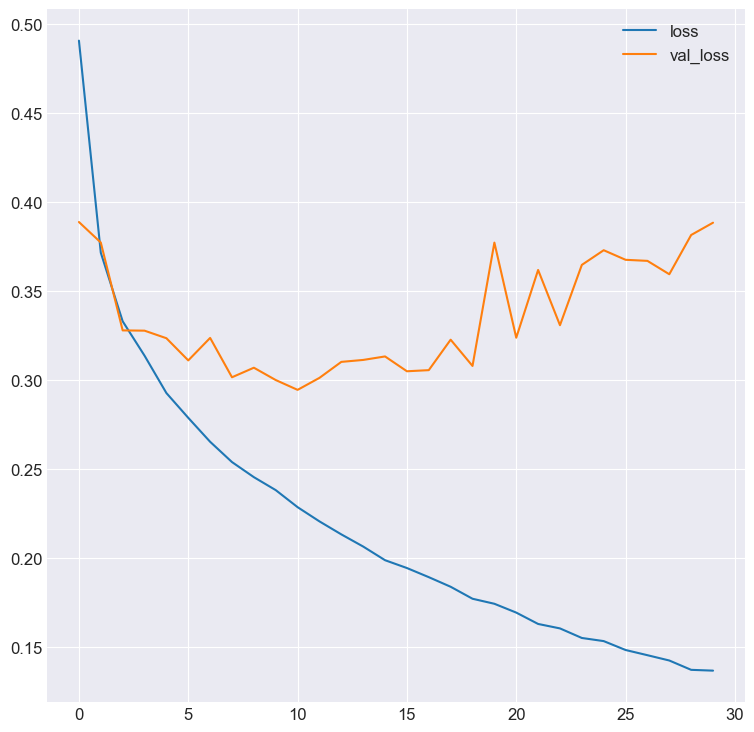

In [28]:
ax=loss_df.plot(y=['loss', 'val_loss'])

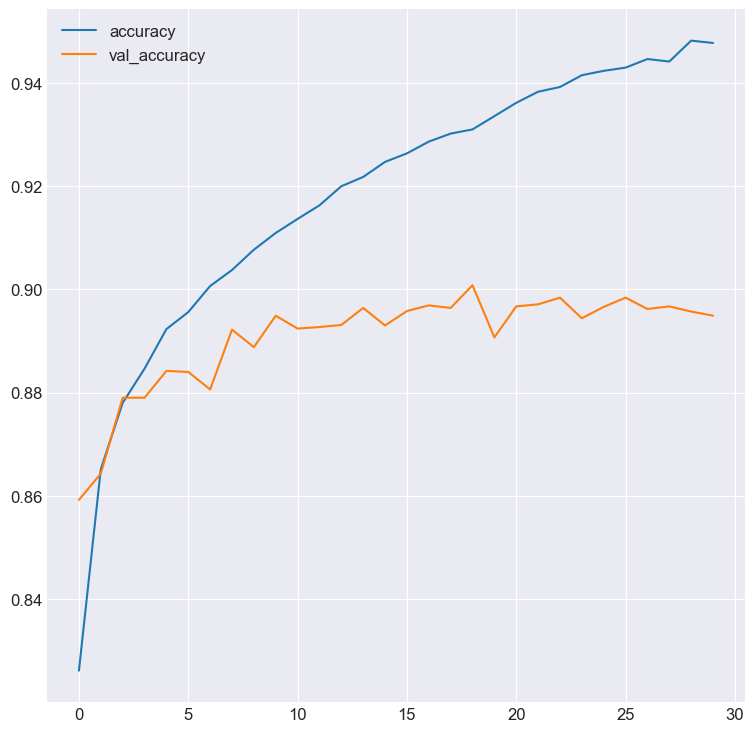

In [29]:
ax= loss_df.plot(y=['accuracy','val_accuracy'])

In [30]:
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred= model.predict(X_test).argmax(axis=1)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


In [31]:
print(f'Accuracy: {accuracy_score(y_train,y_train_pred): .4f}')

Accuracy:  0.9489


In [32]:
print(f'Accuracy: {accuracy_score(y_test,y_test_pred): .4f}')

Accuracy:  0.8949


In [33]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1000
           1       0.98      0.99      0.98      1000
           2       0.89      0.74      0.81      1000
           3       0.89      0.94      0.91      1000
           4       0.80      0.89      0.84      1000
           5       0.97      0.97      0.97      1000
           6       0.70      0.77      0.73      1000
           7       0.97      0.92      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.93      0.98      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [34]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[782,   1,   7,  23,   3,   0, 178,   0,   6,   0],
       [  2, 987,   0,  10,   0,   0,   0,   0,   1,   0],
       [ 13,   2, 740,  11, 136,   0,  96,   0,   2,   0],
       [ 16,  15,   5, 935,  10,   1,  18,   0,   0,   0],
       [  0,   2,  33,  40, 888,   0,  35,   0,   2,   0],
       [  0,   0,   1,   0,   0, 967,   0,  15,   3,  14],
       [ 87,   2,  37,  27,  64,   0, 774,   0,   8,   1],
       [  0,   0,   0,   0,   0,  21,   0, 922,   1,  56],
       [  4,   0,   5,   2,   3,   0,   6,   1, 978,   1],
       [  0,   0,   0,   0,   0,   8,   0,  15,   1, 976]], dtype=int64)

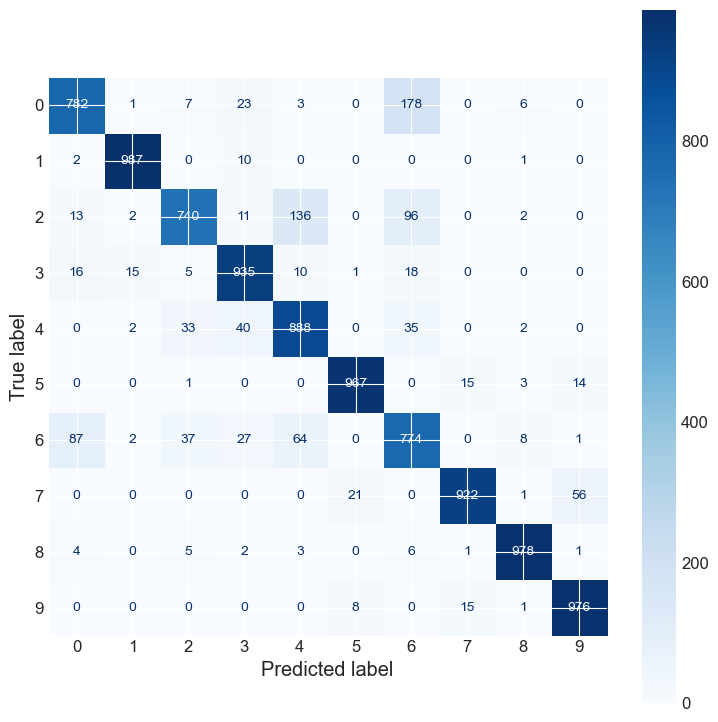

In [35]:
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'Blues')

In [36]:
f1_score(y_test, y_test_pred, average='weighted')

0.8948310340424097

In [37]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      6000
           1       1.00      1.00      1.00      6000
           2       0.96      0.85      0.90      6000
           3       0.94      0.98      0.96      6000
           4       0.86      0.93      0.89      6000
           5       0.99      1.00      1.00      6000
           6       0.84      0.90      0.87      6000
           7       0.99      0.96      0.98      6000
           8       1.00      1.00      1.00      6000
           9       0.97      0.99      0.98      6000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



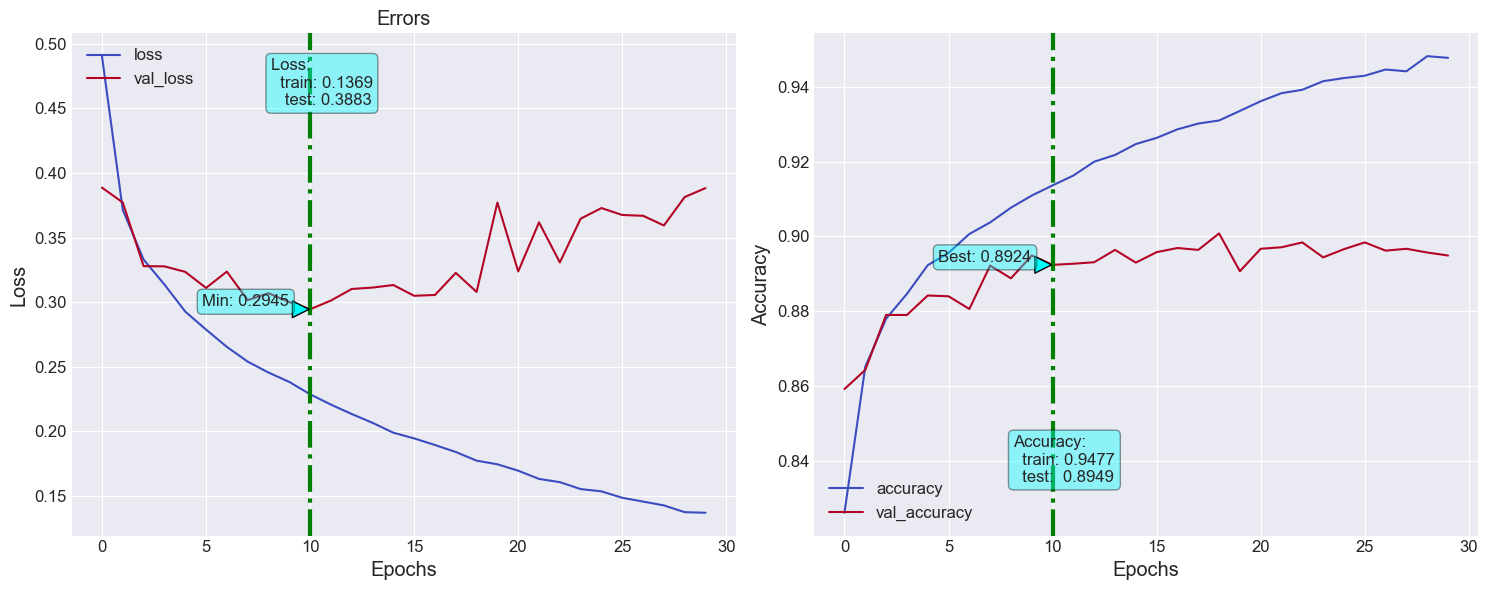

In [38]:
fn_plot_tf_hist(loss_df)

In [92]:
del model

In [94]:
#l2 regularization
regularization= tf.keras.regularizers.L2(0.01)

In [96]:
model1= tf.keras.models.Sequential([
    tf.keras.Input(shape =(784,)),
    tf.keras.layers.Dense(196, kernel_regularizer=regularization,activation='relu'),
    tf.keras.layers.Dense(49, kernel_regularizer=regularization ,activation= 'relu'),

    tf.keras.layers.Dense(10)

])

In [98]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model1.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model1.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7518 - loss: 1.6133 - val_accuracy: 0.8035 - val_loss: 0.7720
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8057 - loss: 0.7371 - val_accuracy: 0.8007 - val_loss: 0.7073
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8127 - loss: 0.6827 - val_accuracy: 0.8102 - val_loss: 0.6806
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8190 - loss: 0.6468 - val_accuracy: 0.8259 - val_loss: 0.6243
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8264 - loss: 0.6178 - val_accuracy: 0.8316 - val_loss: 0.6041
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8341 - loss: 0.5940 - val_accuracy: 0.8341 - val_loss: 0.5875
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8372 - loss: 0.5699 - val_accuracy: 0.8359 - val_loss: 0.5655
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8380 - loss: 0.5677 - 

In [112]:
loss_df = pd.DataFrame(history.history)

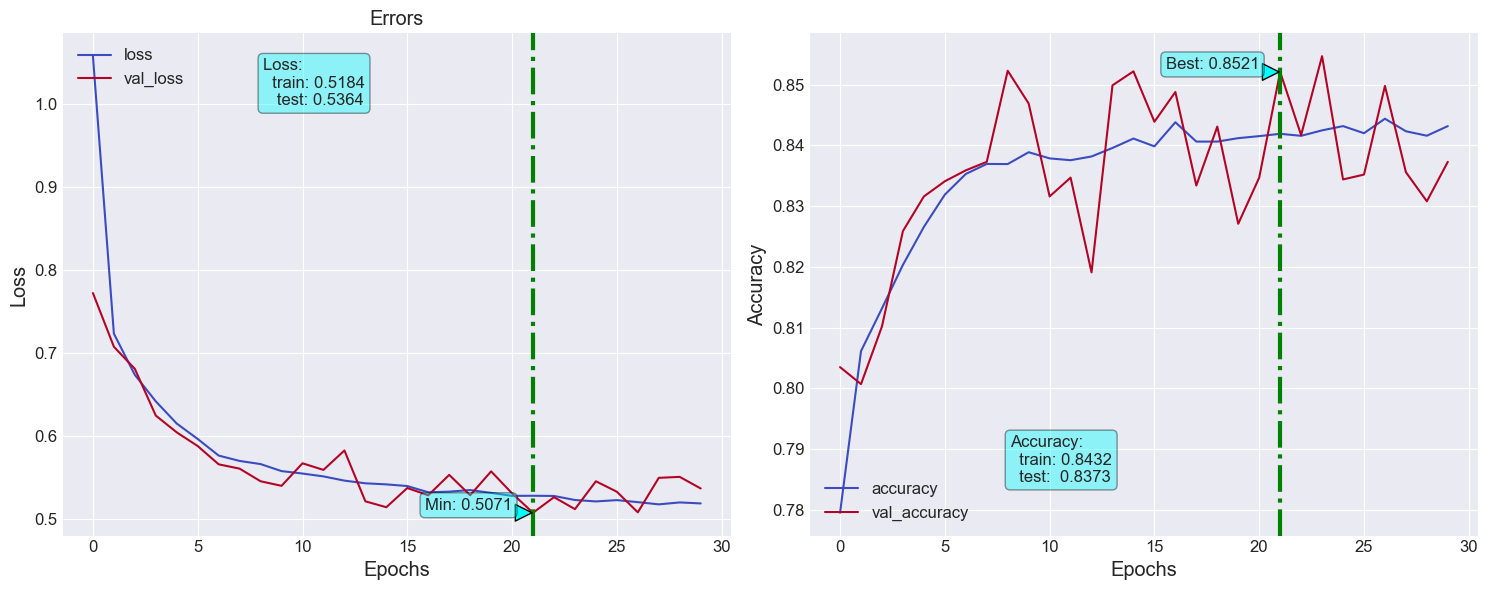

In [114]:
fn_plot_tf_hist(loss_df)

In [301]:
# y_train_pred = model1.predict(X_train).argmax(axis=1)
# y_test_pred= model1.predict(X_test).argmax(axis=1)
# fig, ax= plt.subplots(figsize= (15,6))
# cm = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(cm)
# disp.plot(cmap = 'Blues',ax=ax,colorbar=False)

In [303]:
dor1=0.2
dor2=0.1
dor3=0.3

model2= tf.keras.models.Sequential([
    tf.keras.Input(shape =(784,)),
    # tf.keras.layers.Dropout(rate = dor1, seed = RANDOM_STATE),
    tf.keras.layers.Dense(196 ,activation= 'relu'),
    tf.keras.layers.Dropout(rate = dor2, seed = RANDOM_STATE),
    tf.keras.layers.Dense(49,activation= 'relu'),
    tf.keras.layers.Dropout(rate = dor3, seed = RANDOM_STATE),
              
    tf.keras.layers.Dense(10)])

In [285]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model2.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model2.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7254 - loss: 0.7620 - val_accuracy: 0.8457 - val_loss: 0.4272
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8437 - loss: 0.4330 - val_accuracy: 0.8646 - val_loss: 0.3711
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8569 - loss: 0.3940 - val_accuracy: 0.8730 - val_loss: 0.3508
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8651 - loss: 0.3705 - val_accuracy: 0.8754 - val_loss: 0.3320
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8732 - loss: 0.3531 - val_accuracy: 0.8774 - val_loss: 0.3354
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8787 - loss: 0.3341 - val_accuracy: 0.8784 - val_loss: 0.3255
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8815 - loss: 0.3226 - val_accuracy: 0.8803 - val_loss: 0.3174
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8872 - loss: 0.3076 - 

In [286]:
loss_df = pd.DataFrame(history.history)

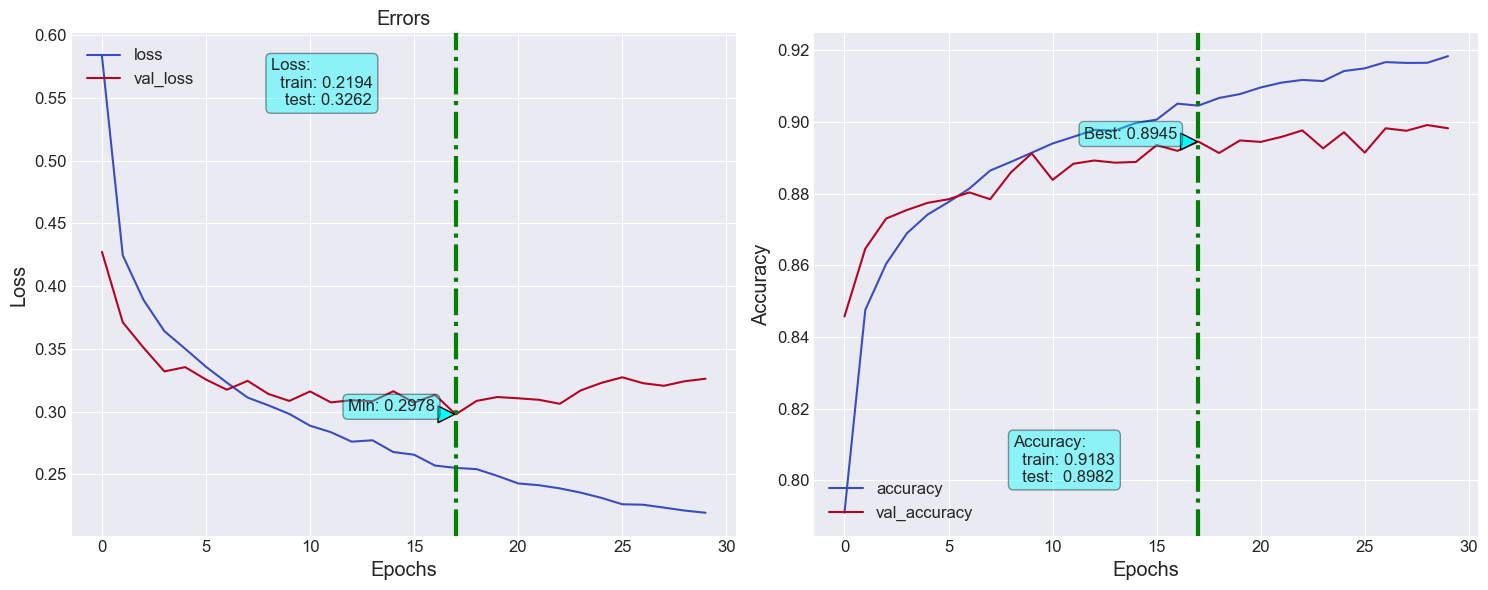

In [287]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


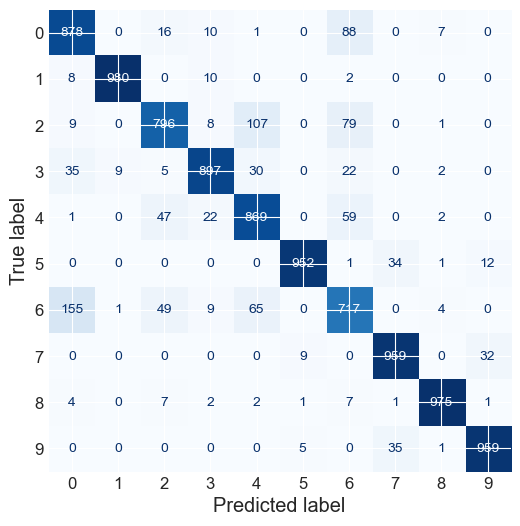

In [288]:
y_train_pred = model2.predict(X_train).argmax(axis=1)
y_test_pred= model2.predict(X_test).argmax(axis=1)
fig, ax= plt.subplots(figsize= (15,6))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'Blues',ax=ax,colorbar=False)

In [299]:
f1_score(y_test, y_test_pred, average='weighted')

0.8983368995294438

In [307]:
####call backs

In [327]:
import os

In [331]:
chkpt_filepath= os.path.join(modelDir, subDir,f'{altName}.weights.h5')
chkpt_filepath

'../models\\fashion_MNIST\\all_in.weights.h5'

In [343]:
EPOCHS = 500
PATIENCE= 20
LR_PATIENCE=10
LR_FACTOR= 0.1

model_chkpt= tf.keras.callbacks.ModelCheckpoint(
    chkpt_filepath,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    restore_best_weights=True)

lrcb =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    min_lr=1e-5,
)
    
    

In [345]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model2.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model2.fit(X_train, y_train,callbacks=[model_chkpt,escb,lrcb],
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/500
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7207 - loss: 0.7913
Epoch 1: val_loss improved from inf to 0.39048, saving model to ../models\fashion_MNIST\all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7215 - loss: 0.7890 - val_accuracy: 0.8608 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 2/500
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.4415
Epoch 2: val_loss improved from 0.39048 to 0.36242, saving model to ../models\fashion_MNIST\all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8424 - loss: 0.4415 - val_accuracy: 0.8679 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 3/500
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.3897
Epoch 3: val_loss improved from 0.36242 to 0.34157, saving model to ../models\fashion_MNIST\all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8589 - loss: 0.3897 - val_accuracy: 0.8776 - val_loss: 0.3416 - 

In [347]:
loss_df = pd.DataFrame(history.history)

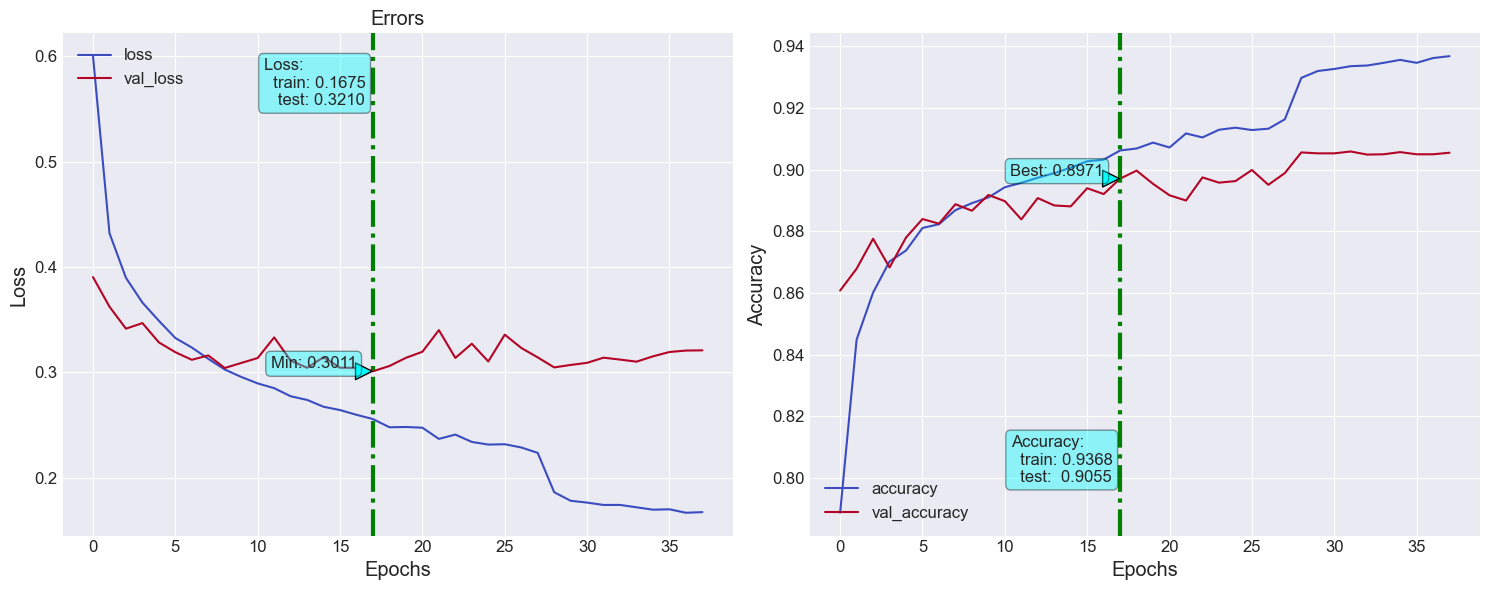

In [349]:
fn_plot_tf_hist(loss_df)

In [355]:
np.exp(710)

C:\Users\duasp\AppData\Local\Temp\ipykernel_1872\574927170.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(710)


inf

In [376]:
dor1=0.2
dor2=0.1
dor3=0.3

model3= tf.keras.models.Sequential([
    tf.keras.Input(shape =(784,)),
    # tf.keras.layers.Dropout(rate = dor1, seed = RANDOM_STATE),
    tf.keras.layers.Dense(196 ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(rate = dor2, seed = RANDOM_STATE),
    
    tf.keras.layers.Dense(49),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(rate = dor3, seed = RANDOM_STATE),
              
    tf.keras.layers.Dense(10)])

In [378]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model3.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model3.fit(X_train, y_train,callbacks=[model_chkpt,escb,lrcb],
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/500
1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7499 - loss: 0.7459
Epoch 1: val_loss did not improve from 0.30113
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7509 - loss: 0.7425 - val_accuracy: 0.8516 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 2/500
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8395 - loss: 0.4503
Epoch 2: val_loss did not improve from 0.30113
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8396 - loss: 0.4502 - val_accuracy: 0.8590 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 3/500
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8561 - loss: 0.4018
Epoch 3: val_loss did not improve from 0.30113
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8561 - loss: 0.4018 - val_accuracy: 0.8716 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 4/500
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.3798
Epoch 4: val_loss did not improve from 0.30113
1875/1875 ━━━━━━━━━━━━━━━━━

In [379]:
loss_df = pd.DataFrame(history.history)

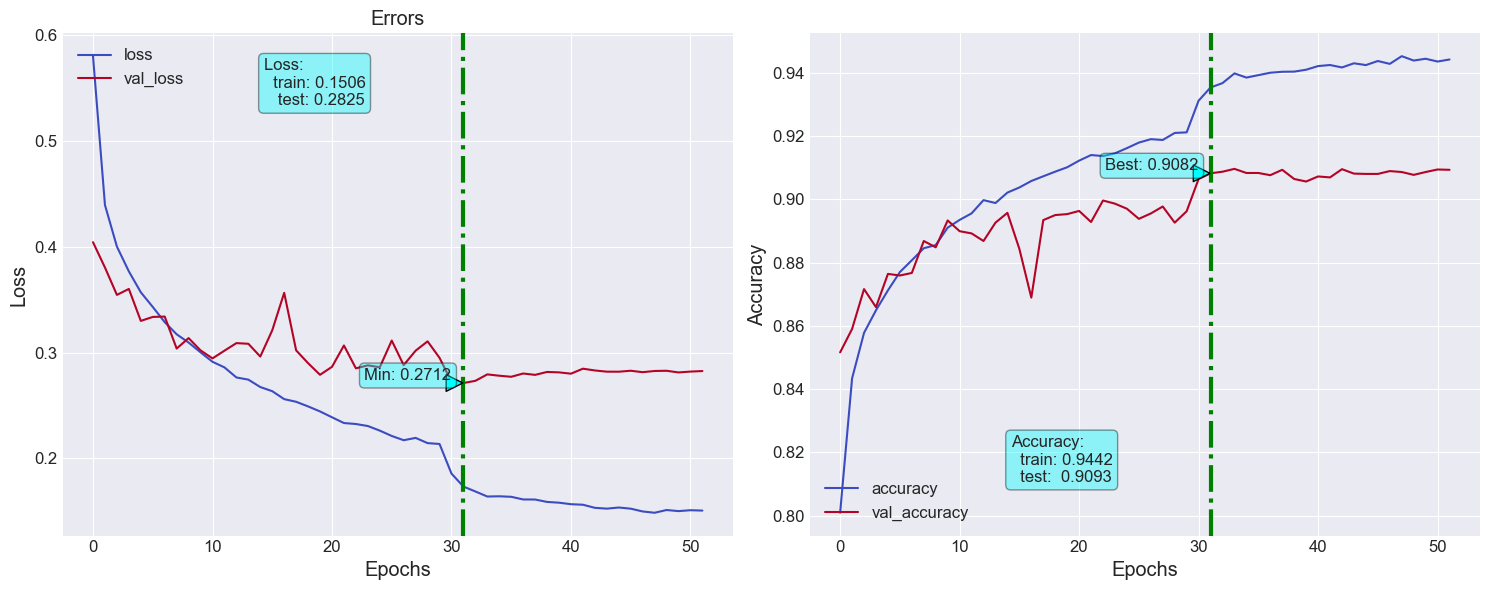

In [380]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


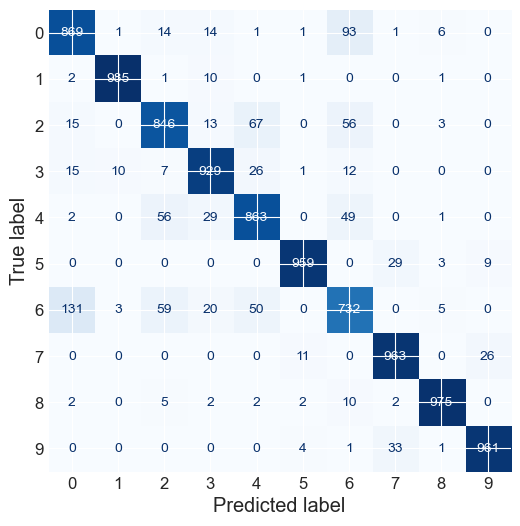

In [381]:
y_train_pred = model3.predict(X_train).argmax(axis=1)
y_test_pred= model3.predict(X_test).argmax(axis=1)
fig, ax= plt.subplots(figsize= (15,6))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'Blues',ax=ax,colorbar=False)

In [386]:
f1_score(y_test, y_test_pred, average='weighted')

0.9079403845666227